# 94889 Preliminary Exercise

## Overview

The purpose of this exercise is to provide a quick check on a couple of the technical skills you'll need in Machine Learning for Public Policy Lab (94-889) anbd help us make sure everyone coming in has the necessary pre-requisites including python, data analysis, databases/sql, and machine learning. 

Feel free to use any references (previous class notes, google, stackoverflow, etc) you would like, but please complete the exercise on your own to ensure the work reflects your experience. **Completing this notebook should take you under 2 hours** -- if you're finding you need to take significantly more time on, you may find it difficult to contribute to the project work in the class.

## Problem Background

This notebook makes use of a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help alleviate this financial burden on teachers by allowing them to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers). Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

### The Modeling Problem

For the purposes of this exercise, we'll imagine that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has time to review and support only 10% of the projects posted to the platform on a given day. 

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to identify projects that are least likely to be fully funded before they expire and pass them off to the digital content expert for review.


# Getting Set Up

Running the code below will create a local postgres 11 database for you and import the sampled donors choose data. Don't worry about the details of that and you shouldn't need to touch any of the code here aside from running it. Below, we'll talk about how to access the database from within the notebook to run queries.

In [ ]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ bionic-pgdg main
 * Starting PostgreSQL 11 database server
   ...done.
ALTER ROLE
DROP DATABASE
CREATE DATABASE
env: DEMO_DATABASE_NAME=donors_choose
env: DEMO_DATABASE_HOST=localhost
env: DEMO_DATABASE_PORT=5432
env: DEMO_DATABASE_USER=postgres
env: DEMO_DATABASE_PASS=postgres


In [ ]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp

In [ ]:
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [ ]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)

# Querying the Database

The code block above used the `sqlalchemy` module to create a connection to the database called `db_engine`. An easy way to run SQL queries against this database is to use the `read_sql` command provided by `pandas`. For instance, if you run the example below, it should return the number of projects in the sampled dataset (16,480):

In [ ]:
pd.read_sql("SELECT COUNT(*) FROM data.projects", db_engine)

,count
0,16480


You can find some more details about the dataset on the [KDD Cup page](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data), but here is a quick description of the four main source tables:
- `data.projects` contains information about each project that was posted on the site, including IDs for the project, school, and teacher, as well as the total amount being requested (note that projects can also request additional "optional support" but don't need to reach this higher bar to be funded)
- `data.essays` has project titles and descriptions
- `data.resources` has information about the specific resources being requested
- `data.donations` contains details about each donation that was received by a project (when it came in, the amount, whether it was from another teacher, etc.)

## Want other packages?
If you need to install any other python modules for your analysis, you can easily do so from a code block by prefixing your `pip install` command with an `!` character. For instance:
```
!pip install PyYAML
```

# QUESTION 1

**(A)** Write a query to return the school id, title, short description, date posted, and total asking price for the most recently posted project from each school in Oregon.

In [ ]:
pd.read_sql(
    "SELECT p2.schoolid, e.title, e.short_description, e.date_posted, p2.total_asking_price \
     FROM ( \
          SELECT schoolid, MAX(date_posted) AS recent_date \
          FROM data.projects \
          WHERE school_state = 'OR' \
          GROUP BY schoolid \
          ) p1 \
          JOIN data.projects p2 \
              ON p1.schoolid = p2.schoolid AND p1.recent_date = p2.date_posted \
          JOIN data.essays e \
              USING (projectid_str) \
     WHERE p2.school_state = 'OR' \
     ",
    db_engine
)

,schoolid,title,short_description,date_posted,total_asking_price
0,d61b06fffec84e74406fd9b79b83f676,STEM Towers Engineering Project,"Build it and they will come!"" Students will ha...",2013-08-27,648.93
1,e86e6f6826167263fe4c358ce12eb21f,Academic English,My students are learning English as a second l...,2013-02-19,198.98
2,ca7c1b50e18e22c9c97e91d429cbaca8,Scrabble Wars,"Language shapes the way we think, and determin...",2012-12-08,301.22
3,2fb6bd29ba665d9e98727a52753477c5,Recycling Project,"Robert Alanr said, ""We can help educate our fa...",2011-02-15,495.59
4,e5119574d9b41fb7200594899f23ba41,Technology to Increase Student Learning,My students are getting more exposure to diffe...,2013-09-03,793.06
5,d61b06fffec84e74406fd9b79b83f676,STEM Green Chemical Engineering Project,"Teaching at a public, science magnet school, o...",2013-08-27,327.64
6,b688c7b721152811d3012ef4493676c0,Help Us Buy Quality Literature For Our English...,"As a new school, we are working to build our c...",2012-01-09,452.65
7,16c2e091c46696b6af2321a68fc9f53a,iPad Differentiation!,Do you remember the first time you had the abi...,2013-10-06,1665.96
8,28af7a22c4a224d9450b9b7aee7261e7,Lifting Our Way to a Healthier Day,My students are looking for new ways to build ...,2011-11-13,598.57
9,c3d3bd57df48d9f90fe71d66139a0830,Measuring Up the Greenhouse,Nothing is more rewarding than watching life h...,2012-07-31,619.26


**(B)** Create a scatter plot of the number of resources requested vs fraction of the total ask amount that was funded across all projects in New Hampshire. (Hint: You'll need to join a couple of tables here to figure out the amount donated to a project)

In [ ]:
!pip install seaborn
!pip install matplotlib

Assumption 1: 
"Number of resources requested" includes the same resource that is requested multiple times.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

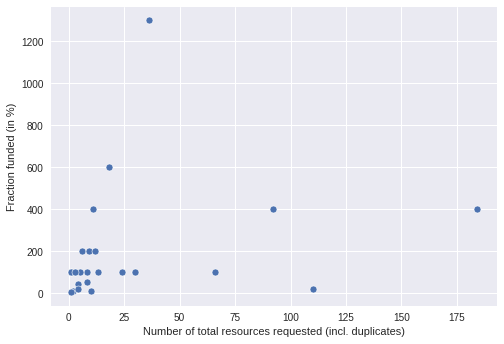

In [ ]:
data = pd.read_sql(" \
    SELECT SUM(r.item_quantity) AS number_of_total_resources, \
        100*SUM(d.donation_to_project)/p.total_asking_price AS fraction_funded \
    FROM data.donations d \
        JOIN data.resources r \
            USING (projectid_str) \
        JOIN data.projects p \
            USING (projectid_str) \
    WHERE school_state = 'NH' \
    GROUP BY d.projectid_str, p.total_asking_price \
    ",
    db_engine
)

p = sns.scatterplot(
    data = data,
    x = "number_of_total_resources",
    y = "fraction_funded")
p.set_xlabel("Number of total resources requested (incl. duplicates)")
p.set_ylabel("Fraction funded (in %)")
plt.show()

Assumption 2:
"Number of resources requested" means number of *unique* resources requested for the respective project. E.g., if the same resource is requested multiple times or in a quantity larger than 1, it is still counted as 1.

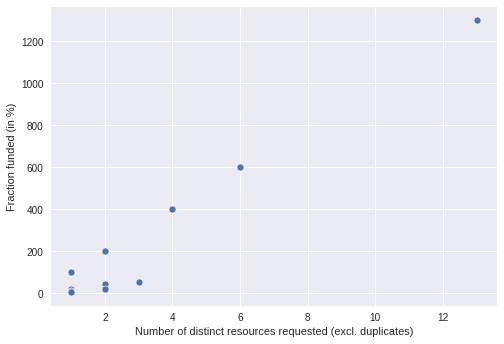

In [ ]:
data = pd.read_sql(" \
    SELECT COUNT(DISTINCT(r.resourceid)) AS number_of_distict_resources, \
        100*SUM(d.donation_to_project)/total_asking_price AS fraction_funded \
    FROM data.donations d \
        JOIN data.resources r \
            USING (projectid_str) \
        JOIN data.projects p \
            USING (projectid_str) \
    WHERE school_state = 'NH' \
    GROUP BY projectid_str, p.total_asking_price \
    ",
    db_engine
)

p = sns.scatterplot(
    data = data,
    x = "number_of_distict_resources",
    y = "fraction_funded")
p.set_xlabel("Number of distinct resources requested (excl. duplicates)")
p.set_ylabel("Fraction funded (in %)")
plt.show()

# QUESTION 2

For this question, you'll develop a model to help DonorsChoose identify 10% of projects to have their digital content expert review based on their risk of failing to reach their funding goal. In order to intervene early in the process, DonorsChoose wants to identify these projects to help immediately upon being posted to the site.

Build and evaluate the performance of a handful of machine learning models. **Be sure to use comments or text blocks to discuss the choices and assumptions you're making along the way.** Note that you don't need to explore an extensive model space here -- building 3 or 4 models should be fine for the purposes of this exercise. Feel free to use any python packages available (such as sklearn) for this.

In [ ]:
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

Assumptions:
- Requested resources are often posted on the date the project is posted but not always. Hence, it is an unreliable predictor and will not be used here. The only data that is always reliably available when the project is posted comes from the `data.projects` table.
- We are avoiding to use the gender of the teacher in order to reduce gender discrimation resulting from our model. It may still discriminate but would presumambly do somewhat less so without the feature.

In [ ]:
## Sourcing data

data = pd.read_sql(
    """SELECT p.projectid_str, funding, p.total_asking_price, \
            p.teacher_acctid, p.school_latitude, \
            p.school_longitude, p.school_city, \
            p.teacher_teach_for_america, \
            p.teacher_ny_teaching_fellow, p.primary_focus_subject, \
            p.primary_focus_area, p.secondary_focus_subject, p.secondary_focus_area, \
            resource_type, p.poverty_level, p.grade_level, \
            p.students_reached, p.fulfillment_labor_materials, \
            p.eligible_double_your_impact_match, "eligible_almost_home_match" \
     FROM data.projects p \
            JOIN ( \
                SELECT projectid_str, \
                    CASE \
                        WHEN SUM(d2.donation_to_project)/p2.total_asking_price < 1 THEN 'not_reached' \
                        ELSE 'reached' \
                    END funding \
                FROM data.donations d2 JOIN data.projects p2 USING (projectid_str) \
                GROUP BY projectid_str, p2.total_asking_price) d \
            USING (projectid_str) \
     """,
    db_engine
)

**Feature Engineering**

In [ ]:
# Data Transformations

# setting project ID as index
df = data.set_index('projectid_str')

# turning y-value to 0/1 variable 
df.loc[df["funding"] == "reached", "funding"] = 0
df.loc[df["funding"] == "not_reached", "funding"] = 1
df["funding"] = df["funding"].astype('int')

In [ ]:
# EDA
sum(df["funding"])/len(df)

0.18579660489020403

Roughly 81% of projects reach their funding goal, leaving 19% underfunded.

In [ ]:
df.isna().sum() * 100 / len(df)

funding                               0.000000
total_asking_price                    0.000000
teacher_acctid                        0.000000
school_latitude                       0.000000
school_longitude                      0.000000
school_city                           0.000000
teacher_teach_for_america             0.000000
teacher_ny_teaching_fellow            0.000000
primary_focus_subject                 0.000000
primary_focus_area                    0.000000
secondary_focus_subject              33.055599
secondary_focus_area                 33.055599
resource_type                         0.000000
poverty_level                         0.000000
grade_level                           0.000000
students_reached                      0.000000
fulfillment_labor_materials           4.625448
eligible_double_your_impact_match     0.000000
                                      0.000000
dtype: float64

In [ ]:
df.drop(
    ["secondary_focus_subject", "secondary_focus_area", "fulfillment_labor_materials"],
    axis = 1,
    inplace = True)

We are dropping three columns as they have a significant amount of missing values.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


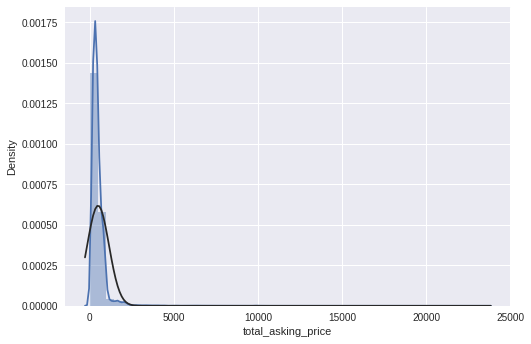

In [ ]:
# Models

sns.distplot(df['total_asking_price'], fit=stats.norm)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


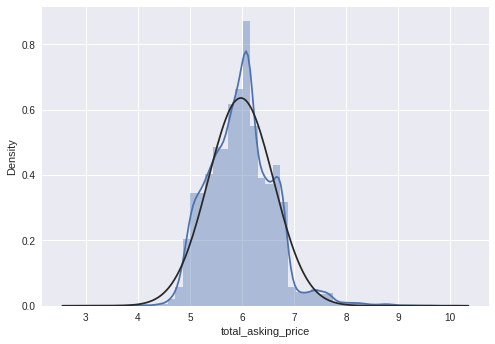

In [ ]:
df['total_asking_price'] = np.log(df['total_asking_price'])
sns.distplot(df['total_asking_price'], fit=stats.norm)
plt.show()

Some predictors are skewed. For example, the `total_asking_price` predictor can be improved with a log transformation. To standardise and center all other variables as well, 

In [ ]:
# Defining features and target
df = pd.get_dummies(df)
X = df.drop('funding', axis=1)
y = df['funding']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=314)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We convert categorical variables to one-hot-vectors. However, the features were selected in the previous step to have as few categorical variables as possible because they dramatically increase the feature space creating problems such as the "curse of dimensionality" (e.g., for knn).

**Selecting the model**

In [ ]:
# Defining models

lm = make_pipeline(RobustScaler(), LogisticRegression())
nb = make_pipeline(RobustScaler(), GaussianNB())
svm = make_pipeline(RobustScaler(), SVC())
nn = make_pipeline(RobustScaler(), MLPClassifier())
knn = make_pipeline(RobustScaler(), KNeighborsClassifier())
rf = make_pipeline(RobustScaler(), RandomForestClassifier())
ada = make_pipeline(RobustScaler(), AdaBoostClassifier())



In [ ]:
models = {
  'Logistics Regression': lm,
  'Naive Bayes': nb, 
  'Support Vector Machine': svm,
  'MLP Neural Network': nn,
  'k-Nearest-Neighbour': knn,
  'Random Forest': rf,
  'AdaBoost': ada
}

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
for m in models.keys():
      score = cross_val_score(models[m], X_train, y_train, cv=5)
      print("\n{} score: {:.4f} ({:.4f})".format(m, score.mean(), score.std()))


Logistics Regression score: 0.7784 (0.0007)

Naive Bayes score: 0.4597 (0.0068)

Support Vector Machine score: 0.8098 (0.0008)

MLP Neural Network score: 0.7334 (0.0258)

k-Nearest-Neighbour score: 0.8139 (0.0014)

Random Forest score: 0.8108 (0.0017)

AdaBoost score: 0.8059 (0.0016)


In [ ]:
final_model = models['k-Nearest-Neighbour']
model = final_model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
sum(y_pred)/len(y_pred)

0.01541815916523906

Only 1.54% of test observations are labelled as at risk of underfunding. However, we are aiming for a figure that is closer to 10%. For that, we are using a method called "upsampling". We are increasing the share of observations (by an arbitrary factor of 2 -- this could be fine tuned in the future) that are labelled as "funding not reached".

In [ ]:
X_train_upsampled = X_train
y_train_upsampled = np.array(y_train)
for i in range(0, len(X_train)):
    if y_train[i] == 1:
        X_train_upsampled = np.vstack((X_train_upsampled, X_train[i,:]))
        y_train_upsampled = np.append(y_train_upsampled, y_train[i])

X_train = X_train_upsampled
y_train = y_train_upsampled

In [ ]:
lm = make_pipeline(RobustScaler(), LogisticRegression())
nb = make_pipeline(RobustScaler(), GaussianNB())
nn = make_pipeline(RobustScaler(), MLPClassifier())
knn = make_pipeline(RobustScaler(), KNeighborsClassifier())
rf = make_pipeline(RobustScaler(), RandomForestClassifier())
ada = make_pipeline(RobustScaler(), AdaBoostClassifier())

models = {
  'Logistics Regression': lm,
  'Naive Bayes': nb, 
  'MLP Neural Network': nn,
  'k-Nearest-Neighbour': knn,
  'Random Forest': rf,
  'AdaBoost': ada
}

In [ ]:
for m in models.keys():
      score = cross_val_score(models[m], X_train, y_train, cv=5)
      print("\n{} score: {:.4f} ({:.4f})".format(m, score.mean(), score.std()))


Logistics Regression score: 0.8607 (0.0004)

Naive Bayes score: 0.5247 (0.0062)

MLP Neural Network score: 0.8163 (0.0059)

k-Nearest-Neighbour score: 0.7193 (0.0006)

Random Forest score: 0.9529 (0.0037)

AdaBoost score: 0.7258 (0.0038)


We now fit our model with the entire training dataset and predict on the testing data that we set aside.

In [ ]:
final_model = models['Random Forest']
model = final_model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
sum(y_pred)/len(y_pred)

0.09372371904687743

In [ ]:
sum(y_pred == y_test)/len(y_pred)

0.7994081918704252

We note that not only the share of "funding not reached"-labelled observations increased but also the models' accuracies overall as seen in the CV scores.

# Question 3

Write a one-paragraph discussion of your results for a non-technical decision-maker with any recommendations for deployment or next steps.

**Summary**
The results of our modelling is mixed. On the one hand, we were able to mitigate that there is significantly more data for projects that reach their funding target than there is for those that don't with a process called "upsampling". 9% of unseen data is predicted as "at risk" of not reaching its funding target (our goal being 10%). On the other hand, we only have an accuracy of 80% and our false positive rate is at 40%. 

Hence, there are a number of things that should be improved technically. We can improve and test the selection of variables that we are using to make our predictions. We may also fine tune other parameters of our models, e.g., the upsampling factor, and model-specific values. Especially because more complex models performed similarly to simple models, there may be room for improvement. Lastly, the model's performance on a variety of bias metrics should be checked before it is used for decision making processes.

Subsequently, we can deploy our pipeline by feeding new projects into our final model. We know that not far from 10% of models are labelled as at risk of not reaching the right funding level, so we can freely select those that are classified as at risk. 

# Submission

To submit your exercise, please **save a copy** of this notebook containing your code and outputs (you can save it either to google drive or github, but make sure the course staff will have read permissions to access it).

Include a link to your copy of the notebook when you fill out [this survey](https://datascience.wufoo.com/forms/z17mvha70usjfv7/) along with your other details.

Thank you and we're looking forward to a great semester in 94889!